In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

### Question 2.1: Generate m Snapshot Data

Snapshot data generated with m=500, dt=0.01, dx=0.001.


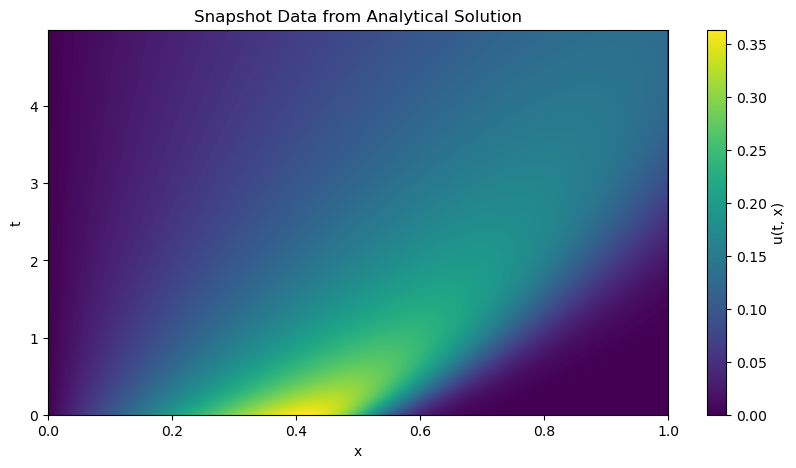

In [2]:
# Parameters for snapshot generation
dt = 1e-2  # Time step
dx = 1e-3  # Spatial grid length
m = 500    # Extend snapshots to cover T = 2.0
t = np.arange(0, m * dt, dt)  # Time grid from t1 to tm
x = np.arange(0, 1 + dx, dx)  # Spatial grid

# Define the analytical solution for the 1D Burgers equation
def analytical_solution(x, t, Re_fixed):
    to = np.exp(Re_fixed / 8)  # Parameter in the equation
    u = x / (t + 1) / (1 + np.sqrt((t + 1) / to) * np.exp(Re_fixed * x**2 / (4 * (t + 1))))
    return u

# Generate snapshot data
Re_fixed = 100  # Reynolds number for this question
usol = np.array([[analytical_solution(xi, ti, Re_fixed) for xi in x] for ti in t])

# Explicitly enforce boundary conditions
usol[:, 0] = 0  # u(0, t) = 0
usol[:, -1] = 0  # u(1, t) = 0

# Verify the boundary conditions
assert np.allclose(usol[:, 0], 0), "Boundary condition u(0, t) = 0 not satisfied"
assert np.allclose(usol[:, -1], 0), "Boundary condition u(1, t) = 0 not satisfied"

# Save snapshot data
np.savez("dataset/Burgers_snapshots.npz", t=t, x=x, usol=usol)
print(f"Snapshot data generated with m={m}, dt={dt}, dx={dx}.")

# Visualize snapshot data
plt.figure(figsize=(10, 5))
plt.imshow(usol, extent=[x.min(), x.max(), t.min(), t.max()], aspect='auto', origin='lower')
plt.colorbar(label="u(t, x)")
plt.title("Snapshot Data from Analytical Solution")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

### Question 2.2: Construct ROM and Determine t∗

In [3]:
# Step 1: Perform SVD

# Load snapshot data
data = np.load("dataset/Burgers_snapshots.npz")
t = data["t"]  # Time grid
x = data["x"]  # Spatial grid
usol = data["usol"]  # Snapshot matrix

# Perform SVD on snapshot matrix A
A = usol
U, S, VT = svd(A, full_matrices=False)

# Select k modes based on cumulative energy threshold
alpha_SVD = 0.01  # Adjusted energy threshold
k = np.sum(np.cumsum(S**2) / np.sum(S**2) < 1 - alpha_SVD)
if k == 0:
    raise ValueError("No modes selected. Check the snapshot data or adjust alpha_SVD.")
print(f"Number of selected modes (k): {k}")

# Extract the first k modes
U_k = U[:, :k]  # Temporal coefficients
S_k = S[:k]     # Singular values
V_k = VT[:k, :]  # Spatial modes

# Step 2: Fit uq(ti) Using GPR

# Fit GPR models for each mode q=1,...,k
gp_models = []
for q in range(k):
    kernel = C(1.0, (1e-4, 1e4)) * RBF(1.0, (1e-4, 1e4))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
    gp.fit(t.reshape(-1, 1), U_k[:, q])  # Fit GPR for temporal mode u_q(t)
    gp_models.append(gp)

# Step 3: Predict ROM Solution for New Time Points

# Predict ROM solution u_ROM(t, x)
def predict_u_rom(t_new, x, gp_models, S_k, V_k):
    U_pred = np.zeros((len(t_new), k))
    for q, gp in enumerate(gp_models):
        U_pred[:, q] = gp.predict(t_new.reshape(-1, 1))
    A_pred = np.dot(U_pred * S_k, V_k)  # A ≈ u_ROM(t, x)
    return A_pred

# Example: Predict u_ROM(t, x) for a new time range
t_new = np.arange(0, 2.0, dt)
u_rom_pred = predict_u_rom(t_new, x, gp_models, S_k, V_k)

# Step 4: Determine Maximum Permissible Forecast Time t∗

# Compute average standard deviation σ̄(t')
def compute_avg_std(t_new, gp_models):
    std_total = np.zeros(len(t_new))
    for gp in gp_models:
        _, std = gp.predict(t_new.reshape(-1, 1), return_std=True)
        std_total += std
    return std_total / len(gp_models)

# Determine t* based on σ̄(t') ≤ σ_tolerance
sigma_tolerance = 0.01  # Allowed prediction error threshold
std_avg = compute_avg_std(t_new, gp_models)

if std_avg.size == 0:
    raise ValueError("No permissible forecast time found. Check GPR models or sigma_tolerance.")

t_star_index = np.where(std_avg <= sigma_tolerance)[0][-1]
t_star = t_new[t_star_index]
print(f"Maximum permissible forecast time t^*: {t_star}")


Number of selected modes (k): 2
Maximum permissible forecast time t^*: 1.99


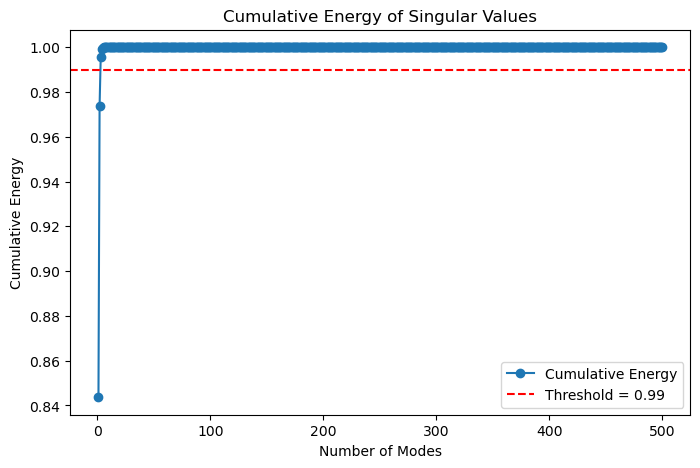

In [4]:
# Visualize cumulative energy of singular values
energy_cumulative = np.cumsum(S**2) / np.sum(S**2)
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(S) + 1), energy_cumulative, marker='o', label="Cumulative Energy")
plt.axhline(1 - alpha_SVD, color='r', linestyle='--', label=f"Threshold = {1 - alpha_SVD}")
plt.xlabel("Number of Modes")
plt.ylabel("Cumulative Energy")
plt.legend()
plt.title("Cumulative Energy of Singular Values")
plt.show()

### Question 2.3: Predict Full-Order Solutions Up to t∗

In [5]:
# Use the ROM to predict up to t*
u_rom_at_t_star = predict_u_rom(np.array([t_star]), x, gp_models, S_k, V_k)

# Save and print the solution at t^*
#np.savez(f"results/full_order_solution_at_t_star_{t_star:.2f}.npz", t_star=t_star, u_full=u_rom_at_t_star)
print(f"Full-order solution at t^* = {t_star} is ready.")

Full-order solution at t^* = 1.99 is ready.


### Question 2.4: Repeat Steps 1-3 Until T=2.0

In [6]:
T_target = 2.0  # Target time
t_current = t  # Current time grid
u_rom_current = usol  # Initial solution

iteration = 0
while np.max(t_current) < T_target:
    iteration += 1
    print(f"Iteration {iteration}: Current maximum time = {np.max(t_current)}")
    
    # Recompute SVD and GPR models
    A = u_rom_current
    U, S, VT = svd(A, full_matrices=False)
    k = np.sum(np.cumsum(S**2) / np.sum(S**2) < 1 - alpha_SVD)
    U_k = U[:, :k]
    S_k = S[:k]
    V_k = VT[:k, :]
    
    gp_models = []
    for q in range(k):
        kernel = C(1.0, (1e-4, 1e4)) * RBF(1.0, (1e-4, 1e4))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
        gp.fit(t_current.reshape(-1, 1), U_k[:, q])
        gp_models.append(gp)
    
    # Predict ROM solution for the new time range
    t_new = np.linspace(np.max(t_current), np.max(t_current) + 0.5, 50)
    u_rom_pred = predict_u_rom(t_new, x, gp_models, S_k, V_k)
    
    # Update current time and solution
    t_current = np.concatenate([t_current, t_new])
    u_rom_current = np.vstack([u_rom_current, u_rom_pred])
    
    # Check if t^* has reached the target time
    if np.max(t_current) >= T_target:
        break

print(f"Long-time prediction completed up to T = {T_target}.")


Long-time prediction completed up to T = 2.0.


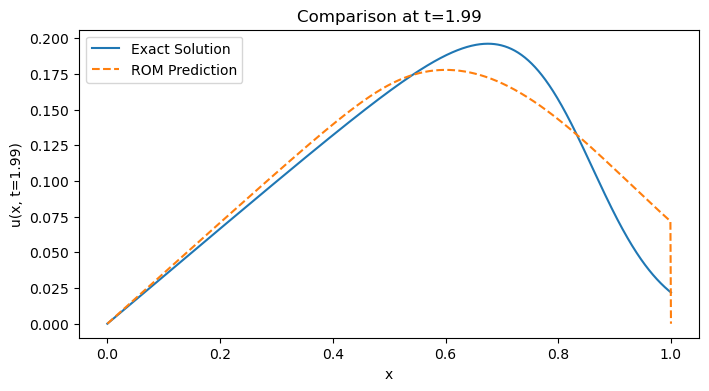

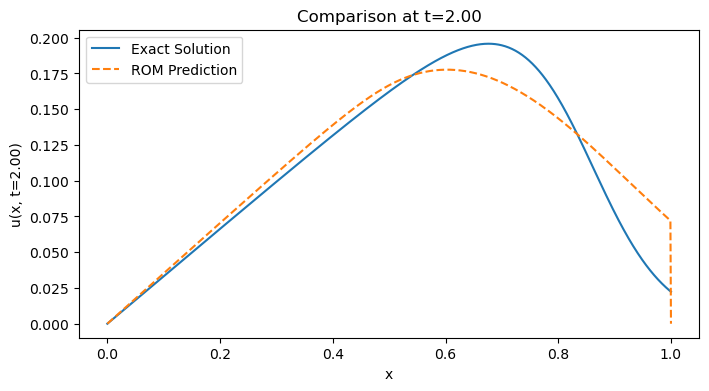

In [7]:
# Compare ROM prediction and exact solution at specific time points
for t_idx, t_val in enumerate([t_star, 2.0]):
    u_rom = predict_u_rom(np.array([t_val]), x, gp_models, S_k, V_k)
    u_exact = np.array([analytical_solution(xi, t_val, Re_fixed) for xi in x])
    
    plt.figure(figsize=(8, 4))
    plt.plot(x, u_exact, label="Exact Solution")
    plt.plot(x, u_rom.flatten(), label="ROM Prediction", linestyle="--")
    plt.xlabel("x")
    plt.ylabel(f"u(x, t={t_val:.2f})")
    plt.title(f"Comparison at t={t_val:.2f}")
    plt.legend()
    plt.show()

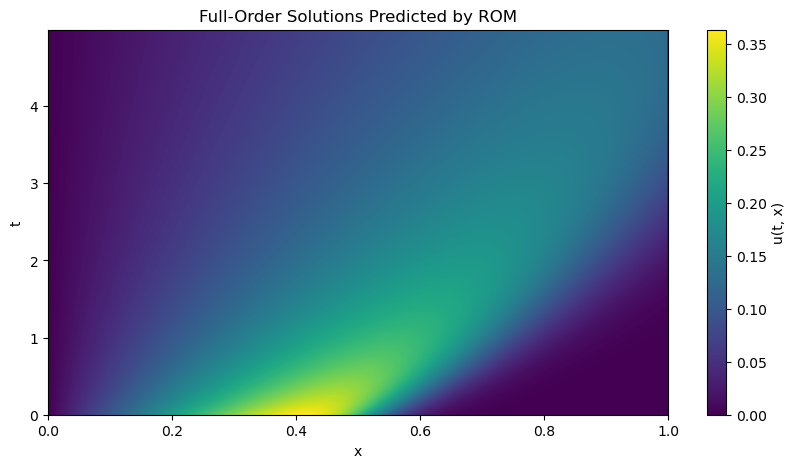

In [8]:
# Visualize full ROM prediction over time
plt.figure(figsize=(10, 5))
plt.imshow(u_rom_current, extent=[x.min(), x.max(), t_current.min(), t_current.max()], aspect='auto', origin='lower')
plt.colorbar(label="u(t, x)")
plt.title("Full-Order Solutions Predicted by ROM")
plt.xlabel("x")
plt.ylabel("t")
plt.show()


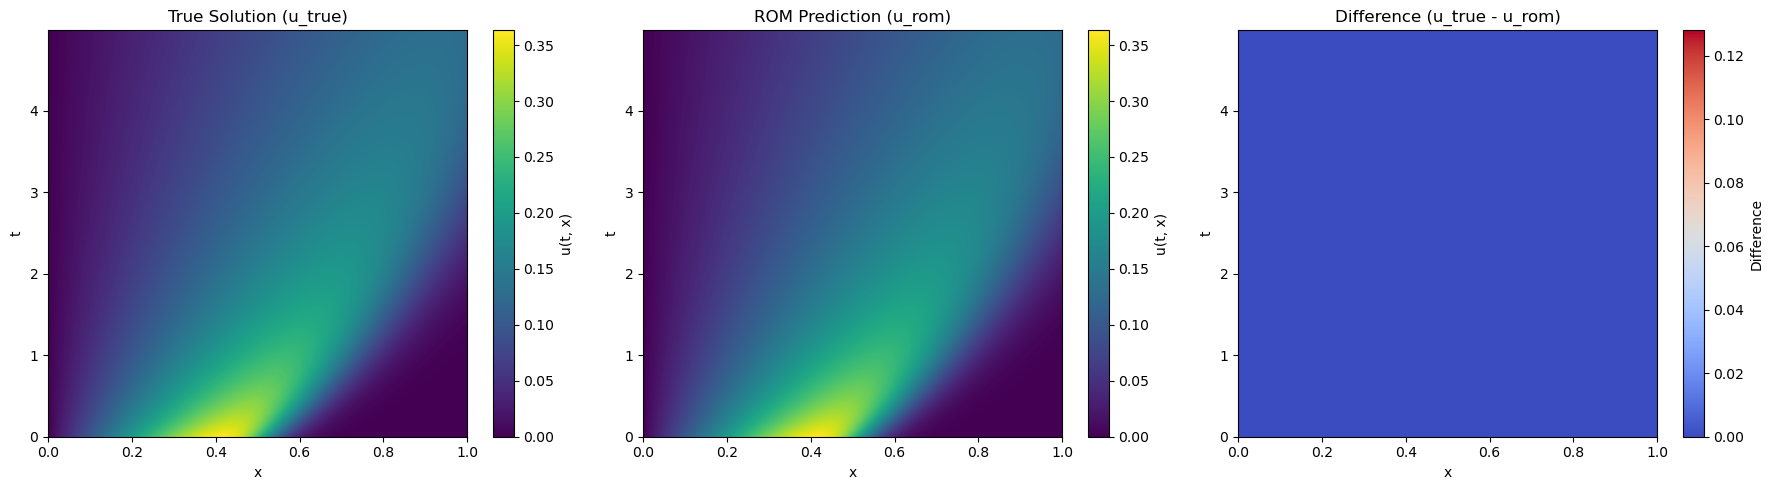

In [9]:
# Generate the reference solution (true solution)
# The true solution should match the shape of the ROM solution
u_true = np.array([[analytical_solution(xi, ti, Re_fixed) for xi in x] for ti in t_current])

# Calculate the difference between the ROM solution and the true solution
u_diff = u_true - u_rom_current

# Create a figure with three subplots for comparison
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Heatmap of the true solution
im1 = axs[0].imshow(u_true, extent=[x.min(), x.max(), t_current.min(), t_current.max()],
                    aspect='auto', origin='lower', cmap='viridis')
axs[0].set_title("True Solution (u_true)")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
fig.colorbar(im1, ax=axs[0], label="u(t, x)")

# Subplot 2: Heatmap of the ROM prediction
im2 = axs[1].imshow(u_rom_current, extent=[x.min(), x.max(), t_current.min(), t_current.max()],
                    aspect='auto', origin='lower', cmap='viridis')
axs[1].set_title("ROM Prediction (u_rom)")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
fig.colorbar(im2, ax=axs[1], label="u(t, x)")

# Subplot 3: Heatmap of the difference (True Solution - ROM Prediction)
im3 = axs[2].imshow(u_diff, extent=[x.min(), x.max(), t_current.min(), t_current.max()],
                    aspect='auto', origin='lower', cmap='coolwarm')
axs[2].set_title("Difference (u_true - u_rom)")
axs[2].set_xlabel("x")
axs[2].set_ylabel("t")
fig.colorbar(im3, ax=axs[2], label="Difference")

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()
